In [17]:
import os
import json
import gzip
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

from collections import Counter

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.linear_model import LinearRegression

# 1 Video filtering

The first section of our code focuses on video filtering around the topic of `mental health` we propose. We adopt a 2-step filtering strategy, where we use snowball sampling based on keywords in the first stage, and further exclude irrelevant categories and unwanted videos in the second. Here's a detailed description of what we have done:

## 1.1. First stage: Snowball sampling based on keywords

### Method

1) We first design a list of keywords ourselves that is supposed to connect to the filed of mental health, e.g. `mental health`, `anxiety`, `depress`...
2) Since the dataset is extremely large, we read the files line by line and process them in a batch size of 200000. Three attributes are taken into account during processing, namely `description`, `tags` and `title`. If **at least two out of three text fields** contain a word in our designed word list, we assume that video is relevant and be retrieved.
3) After retrieving, we check the results by a wordcloud visualization and see if there is any insightful words that occur in the result but is not included in our designed keyword list. If such word exists, we iteratively add them to the list. Here some of the words we added include `sociopath`, `psycho`, etc.
4) Repeat step 1-3 to update the results until no new words can be found.

In [18]:
# keywords for mental health
# The matching algorithm only checks the existence of the given string, 
# so we could use "depress" to represent "depression",# "depressed",# "depressing", etc.

mental_word_list = [
    "mental health", "mental illness", "disorder",
    "solitude", "alone", "lonely", "loneliness",
    "depress",  # "depression",# "depressed",# "depressing",
    "stress", "anxiety", "anxious", # "stress", # "stressing",# "stressed" 
    "suicid", "trauma",
    "[^a-z0-9]ptsd[^a-z0-9]",
    "[^a-z0-9]emo[^a-z0-9]",
    "psycho",
    "psychiatr",
    "psychedelic",
    "sociopath",
]

mental_keywords = "|".join(mental_word_list)

### Comparing trend

It is necessary to extract videos belonging to other topics so that we could make a proper comparison between them. The topics we chose are `climate change`, and `gender equality`, which are all considered as a growing social issues today. In order to do so, we also designed a set of keywords list to extract their corresponding videos respectively.

In [19]:
word_lists_climate = [
    "climate change",
    "global warming",
    "air pollution",
    "greenhouse effect",
    "carbon emissions",
    "carbon footprint",
    "carbon tax"
]
climate_keywords = "|".join(word_lists_climate)

# keywords for gender quality
gender_word_list = [
    "gender equal", "gender inequal", "gender discriminat",
    "sex equal", "sex inqual", "sex discriminat",
    "sexis", "gender egalitari", "sexual egalitari", "sex egalitari",
    "sexual equal", "sexual inequal", "sexual discriminat",
    "sexual harass", "sexual assult",
    "feminis",  # "Feminism", "Feminist"
    "women right", "women's right", "woman right", "woman's right",
    "women power", "women's power", "woman power", "woman's power",
    "girl help girl", "girls help girls", "girl helps girl"
]
gender_keywords = "|".join(gender_word_list)

In [20]:
# Final keywords dictionary
keywords_dict = {
    "mental_health": mental_keywords,
    "gender_equality": gender_keywords,
    "climate_change": climate_keywords,
}

In [21]:
# Relevant videos retrieval
def df_filter(df_metadata: pd.DataFrame, keywords: str):
    """
    Function to build and filter dataframe.
    A record would be kept if at least two out of three text fields (description, tags, title) match with at least one keyword specifed above
    """
    df_meta = df_metadata.copy()
    df_meta = df_meta.dropna(subset=["description", "tags", "title", "upload_date"])

    filter_condition1 = df_meta["description"].str.lower().str.contains(keywords).astype(int)
    filter_condition2 = df_meta["tags"].str.lower().str.contains(keywords).astype(int)
    filter_condition3 = df_meta["title"].str.lower().str.contains(keywords).astype(int)

    # the fulfilled condition needs to be equal or above 2
    filter_condition = filter_condition1 + filter_condition2 + filter_condition3
    df_meta = df_meta[filter_condition >= 2]

    return df_meta.copy()

def get_counter(df_metadata: pd.DataFrame):
    """
    Count how many videos are uploaded per day.
    This is to calculate ratio for the following process.
    """
    df_meta = df_metadata.copy()
    df_meta = df_meta.dropna(subset=["upload_date"])

    df_meta["upload_date"] = pd.to_datetime(df_meta["upload_date"]).dt.to_period("D").astype(str)
    counter_dict = df_meta["upload_date"].value_counts().to_dict()
    
    return Counter(counter_dict)

In [ ]:
# initialize dataframe for all the topics we want to analyze
metadata_df = {}
for topic in keywords_dict.keys():
    metadata_df[topic] = []

tmp_metadata = []

# Specify the file path and batch size
file_path = './data/yt_metadata_en.jsonl.gz'
batch = 2000000

with gzip.open(file_path, mode="rb") as f:
    for idx, row in enumerate(tqdm(f, total=72924794)):
        json_dict = json.loads(row.decode("utf-8"))
        tmp_metadata.append(json_dict)

        # if the amount of data reaches the batch size
        # we transform them into dataframe and process at one time
        if (idx + 1) % batch == 0 and idx != 0:
            df_meta = pd.DataFrame(tmp_metadata)
            cur_counter = get_counter(df_meta)
            counter = counter + cur_counter

            # filter videos and add them to the respective topic list
            for topic, keywords in keywords_dict.items():
                metadata_df[topic].append(df_filter(df_meta, keywords))
                
            # clear the buffer to save space
            tmp_metadata = []
    
    # after the loop over, process and clear what's left in the buffer
    if tmp_metadata:
        df_meta = pd.DataFrame(tmp_metadata)
        cur_counter = get_counter(df_meta)
        counter = counter + cur_counter
        
        for topic, keywords in keywords_dict.items():
            metadata_df[topic].append(df_filter(df_meta, keywords))
        tmp_metadata = []

## 2. Second stage: Filter based on video category and eliminate unnecessary keywords
For the below block, we have done several additional filtering aiming for a more desired outcome.

1. We require that in the `title` of the video, at least one of keywords should exist, which is tighter than the `two out of three requirement` above.
2. We eliminate some videos belonging to categories like `Music`, `Movie` since we inspect the content of the videos and most of them are false positive. Till now, the categories we allow are included in the list `constrained_category`.
3. Specifically for `mental health` videos, we filter some of the undesired contents based on keywords like `monkey`, `malone`, for they show little relevance to the topic.
4. Finally, use a wordcloud figure and display our final results to validate the results we obtained so far.

Before filtering, there are 373939 videos
After filtering, there are 88828 videos


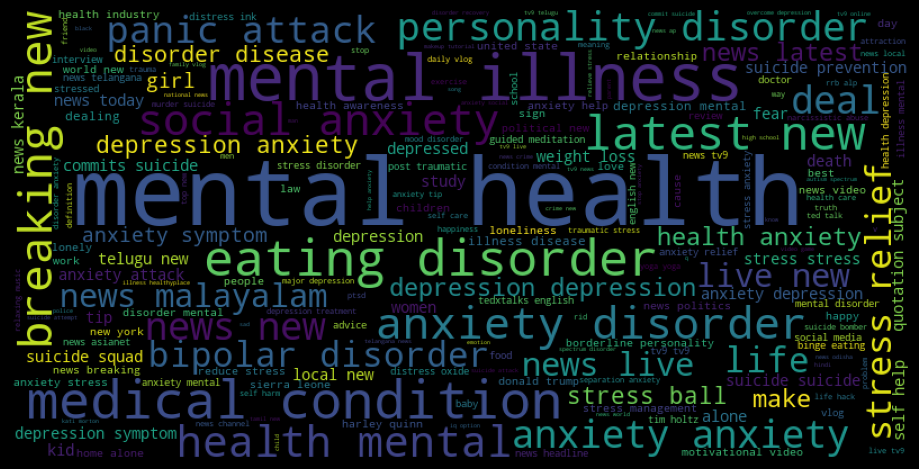

In [22]:
def filter_based_on_category_and_title(df: pd.DataFrame, category: list[str], keywords: str):
    # drop nan and filter nan
    df = df.dropna(subset=["description", "tags", "title", "upload_date", "categories"])
    df = df[df["categories"].isin(category)]
    
    # Ask title to contain keywords
    if keywords is not None:
        df = df[df["title"].str.lower().str.contains(keywords)]
        
    return df

df_meta_mental = pd.read_csv("./data/metadata_mental.csv")

# the restricted category we accept
constrained_category = ["Howto & Style", "Science & Technology", "People & Blogs", "Pets & Animals",
                        "Travel & Events", "Nonprofits & Activism", "News & Politics", "Education", "Nonprofits & Activism"] 

# second stage filter
print("Before filtering, there are %d videos"%len(df_meta_mental))
df_meta_mental = filter_based_on_category_and_title(df_meta_mental, constrained_category, mental_keywords)

# constrain on the time 2006.1 - 2019.9
# since data is a bit weird before and after the time span
df_meta_mental["upload_date"] = pd.to_datetime(df_meta_mental["upload_date"])
df_meta_mental = df_meta_mental[df_meta_mental["upload_date"].dt.date < datetime.date(2019, 10, 1)]
df_meta_mental = df_meta_mental[df_meta_mental["upload_date"].dt.date > datetime.date(2006, 1, 1)]

df_meta_mental = df_meta_mental[~df_meta_mental["tags"].str.lower().str.contains("monkey|malone|lonely planet")]
print("After filtering, there are %d videos"%len(df_meta_mental))


# display the results using a wordcloud
from wordcloud import WordCloud, STOPWORDS

tags = df_meta_mental["tags"].apply(lambda x: str(x).lower().replace(",", " "))
wordcloud = WordCloud(width=800, height=400, stopwords=STOPWORDS).generate(' '.join(tags))

plt.figure(figsize=(9,6), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# save the result
df_meta_mental.to_csv("./data/metadata_mental_final.csv", index=False)

In [23]:
# sample some video content to show
sampled_df = df_meta_mental[["categories", "title"]].sample(frac=1).head(10)

fig = go.Figure(data=[go.Table(
    header=dict(values=['categories', 'title'],
                fill_color='paleturquoise',
                align='center'),
    cells=dict(values=[sampled_df.categories.values, sampled_df .title.values], 
               fill_color='lavender',
               align='left'))
])

# fig.update_layout(
#     autosize=True,
#     width=800,
#     height=400,
# )

fig.show()
fig.write_html("./result/samples.html")

# 2 Trend analysis based on videos uploaded per month from 2006-2019

It is time to show how much videos about mental health are uploaded per month and their growth over the years.

## 2.1 Mental health trend

We display both video numbers and ratios throughout the year and applied a linear regression analysis to analyze its growing trend. We leave out the fluctuating period between 2006-2009 when doing the regression analysis and found the result is statistically significant, indicating a mild yet stable growing trend. To this end, we successfully demonstrate people's growing attention to the topic of mental health on YouTube.

In [42]:
def get_total_count(path, constrained_category, save_path):
    """
    Function to get total uploaded video number per date
    """
     
    # if not exist the file, read the feather file to get video numbers from all the constrained category we specified
    if not os.path.exists(save_path): 
        df_meta_all = pd.read_feather(path)
        df_meta_all = df_meta_all[df_meta_all["categories"].isin(constrained_category)]
        df_meta_all["upload_date"] = pd.to_datetime(df_meta_all["upload_date"]).dt.to_period("M")
        
        total_count_df = df_meta_all["upload_date"].value_counts().to_frame()
        total_count_df["view_count"] = df_meta_all.groupby("upload_date")["view_count"].sum()
        total_count_df["like_count"] = df_meta_all.groupby("upload_date")["like_count"].sum()
        total_count_df["popularity"] = total_count_df["like_count"] + total_count_df["view_count"]
        
        # sort the statistics according to the upload time
        total_count_df.sort_index(inplace=True)
        total_count_df.to_csv(save_path, index=True)
        
    # load the file
    total_count_df = pd.read_csv(save_path, index_col=0)
    total_count_df.index = pd.to_datetime(total_count_df.index).to_period('M')
        
    # Also should be in the time span we specified
    total_count_df = total_count_df[total_count_df.index.to_timestamp().date < datetime.date(2019, 10, 1)]
    total_count_df = total_count_df[total_count_df.index.to_timestamp().date > datetime.date(2006, 1, 1)]
    
    return total_count_df

def get_proportion(dataframe: pd.DataFrame, total_count: pd.Series):
    """
    Function to get the proportion of current topic videos to all videos uploaded in the same month
    """
    df = dataframe.copy()

    # divide current video number by total video number to get the ratio
    df["upload_month"] = pd.to_datetime(df["upload_date"]).dt.to_period('M')
    cur_count = df["upload_month"].value_counts()
    cur_count.sort_index(inplace=True)
    ratio = cur_count.divide(total_count, fill_value=0)
    ratio.index = ratio.index.to_timestamp()

    return ratio

# aggregate based on upload time and plot the histogram
def transform_for_histplot(dataframe: pd.DataFrame):
    """
    Aggregate record numbers monthly based on upload_date
    Return sorted histogram series
    """
    df = dataframe.copy()
    df.upload_date = pd.to_datetime(df.upload_date)
    df['upload_month'] = df['upload_date'].dt.to_period('M')
    df_hist = df['upload_month'].value_counts().sort_index()
    df_hist.index = df_hist.index.to_timestamp()
    return df_hist

In [43]:
# get ratio and number histogram
total = get_total_count("./data/yt_metadata_helper.feather", constrained_category, "./data/total_constrained.csv")
mental_hist = transform_for_histplot(df_meta_mental)
mental_ratio = get_proportion(df_meta_mental, total["count"])

# perform a linear regression analysis
import statsmodels.formula.api as smf
mental_ratio = mental_ratio.to_frame(name="ratio")

mental_ratio.reset_index(inplace=True)
mental_ratio.reset_index(inplace=True)
mental_ratio.rename(columns={"index": "date", "level_0": "index"}, inplace=True)

mental_ratio_LR = mental_ratio[mental_ratio.date.dt.date > datetime.date(2010, 1, 1)].copy()

mod = smf.ols(formula='ratio ~ index', data=mental_ratio_LR)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     31.26
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.57e-07
Time:                        13:14:06   Log-Likelihood:                 768.14
No. Observations:                 116   AIC:                            -1532.
Df Residuals:                     114   BIC:                            -1527.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0025   9.97e-05     24.595      0.0

In [44]:
# use scikit learn to predict the regression result and draw the line
model = LinearRegression()

# Fitting the model with the data
model.fit(np.array(range(len(mental_ratio_LR))).reshape(-1,1), mental_ratio_LR.ratio.values)

# Making predictions
y_pred = model.predict(np.array(range(len(mental_ratio_LR))).reshape(-1,1))

In [47]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# draw the absolute mental health video number with bar chart
fig.add_trace(
    go.Bar(x=mental_hist.index, y=mental_hist.values, name="Number"),
    secondary_y=False,
)

# draw the ratio with line
fig.add_trace(
    go.Scatter(x=mental_ratio.date, y=mental_ratio.ratio, name="Ratio"),
    secondary_y=True,
)

# draw regression result with dashed line
fig.add_trace(
    go.Scatter(x=mental_ratio_LR.date, y=y_pred, name="LR Trend", line=go.scatter.Line(dash='dash')),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Mental health videos uploaded per month from 2006-2019"
)

# Set x-axis title
fig.update_xaxes(title_text="Year")

# Set y-axes titles
fig.update_yaxes(title_text="Number", secondary_y=False)
fig.update_yaxes(title_text="Ratio", secondary_y=True)

fig.show()
fig.write_html("./result/ratio.html")

/Users/scbai/opt/anaconda3/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



## 2.2 Comparing the trends

### 2.2.1 Ratio
Remember our compared topics are : `gender equality` and `climate change`. We only plot their ratio throughout the years and put it into the log scales for a clearer comparison.

It is rather surprising to see that none of the comparing trends shows a dramatic increase for their ratios. Nonetheless, mental health issues receives more attention than the comparing topics.

Also, We hypothesize that maybe remaining a stable uploading ratio already means a sustained and consistent attention indicating it is one of the social trend. The upward trend doesn't show because the ranges of videos on YouTube are increasingly explored making the total numbers of videos rises comparably faster than videos from the specific topic.

In [48]:
def load_dataframe(topics: list):
    """
    Load csv files of other topics into dataframes
    """
    df_dict = {}
    for topic in topics:
        df_dict[topic] = pd.read_csv("./data/metadata_%s.csv"%topic)
        # Also filter the videos based on the constrained category
        df_dict[topic] = filter_based_on_category_and_title(df_dict[topic], constrained_category, keywords_dict[topic])#None)
    return df_dict

compared_topics = ["gender_equality", "climate_change"]
df_dict = load_dataframe(compared_topics)

In [49]:
def plot_by_group(ratio_dict, save_path, title):
    
    fig = make_subplots()
    
    # plot the ratios for the comparing topics
    for topic in ratio_dict:
        fig.add_trace(
            go.Scatter(x=ratio_dict[topic].index, y=ratio_dict[topic].values, name=topic),
        )
        
    
    # Add figure title
    fig.update_layout(
        title_text=title
    )
    
    # Set x-axis title
    fig.update_xaxes(title_text="Year")
    
    # Set y-axes titles
    fig.update_yaxes(title_text="Ratio")
    fig.update_yaxes(type="log")
    
    fig.show()
    fig.write_html(save_path)
    # Plot the first subplot

# draw the comparison
ratio_dict = {}
for topic in compared_topics:
    ratio_dict[topic] = get_proportion(df_dict[topic], total["count"])

mental_ratio = mental_ratio.set_index("date", drop=True)["ratio"]
ratio_dict["mental_health"] = mental_ratio

plot_by_group(ratio_dict, "./result/comparison.html", "Comparison of videos uploaded per month from 2006-2019")

### 2.2 Popularity

Ratio of the uploaded video number is not everything, what about the popularity of the videos? Here, we define the popularity score as `popularity_score` = `view_count` + `like_count`, and let's compare the ratio of the popularity score of the videos:

In [30]:
def get_popular_proportion(dataframe: pd.DataFrame, total_count: pd.Series):
    """
    Function to get the proportion of current topic videos to all videos uploaded in the same month
    """
    df = dataframe.copy()

    # divide current video number by total video number to get the ratio
    df["upload_month"] = pd.to_datetime(df["upload_date"]).dt.to_period('M')
    popular_df = df.groupby("upload_month")["view_count"].sum() + df.groupby("upload_month")["like_count"].sum()
    popular_df.sort_index(inplace=True)
    popular_ratio = popular_df.divide(total_count, fill_value=0)
    popular_ratio.index = popular_ratio.index.to_timestamp()

    return popular_ratio

popular_dict = {}
for topic in compared_topics:
    popular_dict[topic] = get_popular_proportion(df_dict[topic], total["popularity"])

mental_popular = get_popular_proportion(df_meta_mental, total["popularity"])
popular_dict["mental_health"] = mental_popular

plot_by_group(popular_dict, "./result/popular.html", "Comparison of popularity of videos uploaded per month from 2006-2019")

# 3. Explore predominant category and the most mentioned group of people in mental health videos

In this section ,we aim to delve deep inside the trend of mental health videos and would like to study two problems:
1) What is the most frequently mentioned group of people? Is teenager problems more mentioned or women?
2) Among all the videos, what is the most frequently mentioned mental issues? Is it `disorder` or `suicide`, etc?
3) Finally, throughout the years, do the situation varies?

To do this We divide the keywords into several groups to our best knowledge, and calculate their frequency according to their appearance in the mental health videos.

## 3.1 Affected people groups

We count the frequency of `man`, `woman`, `teenager` and `senior`. And see that throughout all the years, mental issues regarding `teenager` remains the biggest problem, followed by `woman` and `man`.

In [31]:
def get_proportion(dataframe, types):
    df_meta = dataframe.copy()
    df_meta["upload_date"] = pd.to_datetime(df_meta["upload_date"])
    df_meta = df_meta[df_meta["upload_date"].dt.date < datetime.date(2019, 1, 1)]
    
    # initialize, keys are types, values are lists of proportion over the years
    types_proportion_all = {}
    for t in types.keys():
        types_proportion_all[t] = []
    types_proportion_all["general"] = []
    
    # group by years
    years = []
    for year, df_group in df_meta.groupby(df_meta["upload_date"].dt.year):
        years.append(year)
        types_counter, _ = count_type(df_group, types)
        types_proportion = list(types_counter.values())
        for mental_type, proportion in zip(list(types_counter.keys()), types_proportion):
            types_proportion_all[mental_type].append(proportion)
    
    return types_proportion_all, years

def count_type(dataframe: pd.DataFrame, types: dict):
    """
    Count the occurence of each type
    If none of the types is detected, then it belongs to the general type
    """
    df = dataframe.copy()

    df["text"] = df["title"] +  " " + df["tags"] + " " + df["description"]
    df["is_general"] = 1

    keywords_counter = Counter()
    count_matrix = []

    for m_type, keywords in types.items():
        if_contains_keywords = df["text"].str.lower().str.contains(keywords).astype(int)
        count_matrix.append(if_contains_keywords.values)
        
        keywords_counter[m_type] = if_contains_keywords.sum()
        # df.loc[if_contains_keywords, "is_general"] = 0

    count_matrix = np.vstack(count_matrix)

    return keywords_counter, count_matrix

def draw(df_meta, types: dict, title: str, save_path):
    
    # get types and proportions for each group
    types_counter, matrix = count_type(df_meta, types)
    types_proportion, years = get_proportion(df_meta, types)

    fig = make_subplots(rows=1, cols=2, column_widths=[0.4, 0.6], horizontal_spacing=0.15)
    fig.add_trace(go.Bar(x=list(types_counter.keys()), y=list(types_counter.values())), row=1, col=1)
    
    # we do not want to plot the `general` group anymore, as it contains little information
    for mental_type, proportions in types_proportion.items():
        if mental_type == "general":
            continue
        fig.add_trace(go.Line(x=years, y=proportions, name=mental_type,), row=1, col=2)
        
    # Format the figure
    for trace in fig['data']: 
        if(trace['name'] not in list(types.keys())):
            trace['showlegend'] = False
    
    fig.update_layout(title_text=title)
    
    fig.update_xaxes(title_text="Type", row=1, col=1)
    fig.update_yaxes(title_text="Related video number", row=1, col=1)
    fig.update_xaxes(title_text="Year", row=1, col=2)
    fig.update_yaxes(title_text="Related video number over the years", row=1, col=2)

    fig.show()
    fig.write_html(save_path)
    
    return matrix
    
# people groups we divide, note they are not mutually exclusive!
people_types = {
    "man": ["[^a-z0-9]man[^a-z0-9]", "[^a-z0-9]men[^a-z0-9]", "[^a-z0-9]husband[^a-z0-9]", "[^a-z0-9]father[^a-z0-9]", "[^a-z0-9]dad[^a-z0-9]", "gentleman", "gentlemen", "[^a-z0-9]male[^a-z0-9]", "masculine"],
    "woman": ["woman", "women", "wife", "[^a-z0-9]mom[^a-z0-9]", "[^a-z0-9]mother[^a-z0-9]", "pregnant", "[^a-z0-9]lady[^a-z0-9]", "[^a-z0-9]mrs[^a-z0-9]", "female", "feminine",],
    "teenager": ["children", "child", "baby", "young", "teenager", "[^a-z0-9]teen[^a-z0-9]", "pupil",  "school", "student", "college", "[^a-z0-9]grad[^a-z0-9]", "boy", "girl"],
    "senior": ["senior", "old people", "old citizen", "grandfather", "grandmother", "grandmom", "grandparents", "aging", "retire", "elder", "veteran"],
}

for m_type, keywords in people_types.items():
    people_types[m_type] = "|".join(keywords)
  
df_meta_mental = pd.read_csv("./data/metadata_mental_final.csv")  
matrix_people = draw(df_meta_mental, people_types, "Related videos with respect to different groups of people", "./result/people.html")

/Users/scbai/opt/anaconda3/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## 3.2 mental category

Now, let's see the most mentioned category. And we can see `stress` is the most mentioned problem, followed by `suicide` and `depress`. They all show a similar trend of increase all these years.

In [32]:
# mental health types
mental_types = {
    # "general": ["mental health", "mental illness", "[^a-z0-9]emo[^a-z0-9]", "psycho", "psychiatr"],
    "lonely": ["solitude", "alone", "lonely", "loneliness"],
    "depress": ["depress"],
    "stress": ["stress",  "anxiety", "anxious"],
    "suicide": ["suicid"],
    "trauma": ["trauma", "ptsd"],
    "disorder": ["disorder"], # new
}

for m_type, keywords in mental_types.items():
    mental_types[m_type] = "|".join(keywords)
    
df_meta_mental = pd.read_csv("./data/metadata_mental_final.csv")  
matrix_mental = draw(df_meta_mental, mental_types, "Related videos with respect to different types of mental issues", "./result/category.html")

/Users/scbai/opt/anaconda3/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## 3.3 Heatmap
Let's look at the intersection of the above two results! We use a heatmap to display the affected number. Interestingly, stress is the most common mental problems affecting people of all ages, especially teenagers.

In [ ]:
# Plot the heatmap using matrix_people * matrix_mental
import plotly.express as px
fig = px.imshow(matrix_people.dot(matrix_mental.T),
                labels=dict(x="Mental Issues", y="People", color="Number"),
                x=list(mental_types.keys()),
                y=list(people_types.keys())
               )
fig.update_xaxes(side="top")
fig.show()
fig.write_html("./result/heatmap.html")

# 4. Sentiment analysis

In [ ]:
from transformers import pipeline, DistilBertTokenizer

# Initialize a sentiment-analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_length = 512  # Maximum length for DistilBERT

def analyze_sentiment(text):
    try:
        # Truncate the text
        inputs = tokenizer(text, truncation=True, max_length=max_length, return_tensors="pt")
        # Convert back to text (truncate at the maximum length)
        truncated_text = tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)
        # Get sentiment
        return sentiment_pipeline(truncated_text)[0]
    except Exception as e:
        print(e)
        return np.nan

metadata_df['description_sentiment'] = metadata_df['description'].apply(analyze_sentiment)

# export the dataframe to csv file
metadata_df.to_csv('metadata_mental_final_sentiment.csv', index=False)

/Users/doris/anaconda3/envs/cs401/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).
text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).


In [ ]:
import json
def string_to_dict(s):
    if pd.isna(s):
        return None

    try:
        # Replace single quotes with double quotes
        s = s.replace("'", '"')
        # Convert the string to a dictionary
        return json.loads(s)
    except json.JSONDecodeError:
        # Return None if json.loads fails
        return None

# Convert the string representation of the dictionary into an actual dictionary, handling NaN values and malformed strings
if(type(metadata_df['description_sentiment'][0]) == str):
    metadata_df['description_sentiment'] = metadata_df['description_sentiment'].apply(string_to_dict)


# Function to extract the 'label' key
def extract_label(d):
    try:
        if 'label' in d:
            return d['label']
        return None
    except:
        return None

# Extract the 'label' key
metadata_df['label'] = metadata_df['description_sentiment'].apply(extract_label)

# Function to extract the 'score' key
def extract_score(d):
    try:
        if 'score' in d:
            return d['score']
        return None
    except:
        return None

# Extract the 'score' key
metadata_df['score'] = metadata_df['description_sentiment'].apply(extract_score)


In [ ]:
import plotly.graph_objs as go
import pandas as pd

# Assuming 'metadata_df' is your DataFrame with the 'label' and 'score' columns

# Separate the scores based on the sentiment label
positive_scores = metadata_df[metadata_df['label'] == 'POSITIVE']['score']
negative_scores = metadata_df[metadata_df['label'] == 'NEGATIVE']['score']

# Creating histograms for positive and negative scores
negative_trace = go.Histogram(
    x=negative_scores,
    opacity=0.45,
    name='Negative Scores',
    marker=dict(color='blue')
)


positive_trace = go.Histogram(
    x=positive_scores,
    opacity=0.45,
    name='Positive Scores',
    marker=dict(color='red')
)



# Layout settings
layout = go.Layout(
    title='Distribution of Sentiment Scores in Mental Health Videos',
    xaxis=dict(title='Sentiment Score'),
    yaxis=dict(title='Frequency'),
    barmode='overlay'
)

# Create the figure and plot
fig = go.Figure(data=[positive_trace, negative_trace], layout=layout)
fig.show()
fig.write_html("./sentiment_graph/distribution_overall.html")

The overwhelming majority of descriptions have been classified with high sentiment scores, indicating a prevalence of high prediction confidence resulted from strong emotional content. 

The red bars, representing negative sentiment, show a significant number of descriptions with scores clustering near 1.0, suggesting a high degree of negative sentiment in the content. Simultaneously, the green bars for positive sentiment are much fewer in number, yet they also cluster towards the higher end of the score range. 

We can see the intense nature of discussions and narratives around mental health topics on YouTube, where expressions of both support and struggle could be expected to elicit strong emotional responses. 

The stark contrast between the quantities of negative and positive sentiments may also point to a tendency for these videos to address challenging or problematic aspects of mental health more so than positive outcomes or support.

## 4.1 Sentiment Analysis Over Time
This analysis will reveal how the sentiment expressed in video descriptions has changed over the period for which you have data.

In [ ]:

# Convert 'upload_date' to datetime and sort the DataFrame
metadata_df['upload_date'] = pd.to_datetime(metadata_df['upload_date'])
metadata_df.sort_values('upload_date', inplace=True)

# Group by 'upload_date' and calculate the daily sentiment score percentages
daily_sentiment_counts = metadata_df.groupby(['upload_date', 'label']).size().unstack(fill_value=0)
daily_totals = daily_sentiment_counts.sum(axis=1)
daily_sentiment_percentages = daily_sentiment_counts.divide(daily_totals, axis=0)

# Reshape the DataFrame for plotting
daily_sentiment_percentages = daily_sentiment_percentages.stack().reset_index(name='percentage')


# Create a scatter plot with Plotly Express
fig = px.scatter(daily_sentiment_percentages, x='upload_date', y='percentage', 
                 color='label', 
                 title='Percentage of Total Mental Health Videos by Sentiment Score Over Time',
                 labels={'upload_date': 'Date', 'percentage': 'Percentage of Total Videos'},
                 opacity=0.5)

# Update layout for better visualization
fig.update_layout(legend_title_text='Sentiment', xaxis=dict(showgrid=True), yaxis=dict(showgrid=True))

# Show the plot
fig.show()
fig.write_html("./sentiment_graph/distribution_time.html")


Distribution of Sentiments: There is a clear distinction between positive and negative sentiment scores over time. The plot shows a dense concentration of both positive and negative sentiments, with positive sentiments depicted in orange and negative sentiments in blue.

Sentiment Over Time: There doesn't appear to be a stark trend indicating a shift towards more positive or negative sentiment over the years. Both sentiments are well-represented throughout the time period. However, there is a visible density of sentiment expression that remains fairly consistent over time.

Data Clustering: A cluster of data points, especially for positive sentiments, is visible at the lower percentage range, which indicates that on most days, a certain fraction of videos have positive sentiment scores. Negative sentiments seem to be more spread out, potentially suggesting a wider variation in the proportion of videos receiving negative sentiment on any given day.

Potential Overplotting: The graph suggests a potential issue with overplotting, where multiple data points overlap, especially in areas of high data density. This can make it challenging to discern the exact distribution or to identify outliers. Utilizing transparency (alpha blending) can help to mitigate this effect and better reveal the underlying data distribution.


### Sentiment Analysis with Increasing Popularity

This analysis assesses whether there's a correlation between the sentiment of video descriptions and their popularity metrics, such as views, likes, and comments.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Calculate a popularity score
metadata_df['popularity_score'] = metadata_df['view_count'].fillna(0) + metadata_df['like_count'].fillna(0)

# Ensure there are no zero or negative values before taking log
metadata_df['popularity_score'] = metadata_df['popularity_score'].replace(0, np.nan)
metadata_df.dropna(subset=['popularity_score'], inplace=True)

# Define bins in log-space
min_popularity = np.log10(metadata_df['popularity_score'].min())
max_popularity = np.log10(metadata_df['popularity_score'].max())
popularity_bins = np.logspace(min_popularity, max_popularity, num=200)

# Bin the popularity scores with the log bins
metadata_df['popularity_bin'] = pd.cut(metadata_df['popularity_score'], bins=popularity_bins, labels=range(len(popularity_bins)-1))

# Calculate the midpoint of each bin for plotting
def calculate_midpoint(bin_index):
    if bin_index < len(popularity_bins) - 1:
        return (popularity_bins[bin_index] + popularity_bins[bin_index + 1]) / 2
    return np.nan

metadata_df['popularity_bin_mid'] = metadata_df['popularity_bin'].apply(calculate_midpoint)

# Group by the mid-point of popularity bins and calculate the average sentiment score
average_sentiment_by_popularity = metadata_df.groupby('popularity_bin_mid')['adjusted_score'].mean().reset_index()

# Convert 'popularity_bin_mid' to a numeric type if necessary
average_sentiment_by_popularity['popularity_bin_mid'] = pd.to_numeric(average_sentiment_by_popularity['popularity_bin_mid'], errors='coerce')

# Create a line plot with Plotly Express
fig = px.line(average_sentiment_by_popularity, x='popularity_bin_mid', y='adjusted_score', 
              title='Average Sentiment Score of Mental Health Videos by Popularity Score',
              labels={'popularity_bin_mid': 'Popularity Score (Bin Mid-Point)', 'adjusted_score': 'Average Sentiment Score'},
              log_x=True,  # Set the x-axis to a logarithmic scale
             )

# Add points to the line plot for clarity
fig.add_scatter(x=average_sentiment_by_popularity['popularity_bin_mid'], y=average_sentiment_by_popularity['adjusted_score'], mode='markers')

# Update layout for better visualization
fig.update_layout(xaxis=dict(showgrid=True, type='log', gridcolor='LightPink', gridwidth=0.5),
                  yaxis=dict(showgrid=True, gridcolor='LightBlue', gridwidth=0.5))

# Show the plot
fig.show()
fig.write_html("./sentiment_graph/distribution_popularity.html")

/var/folders/hl/ywgzj5kj7x960vjr6rcrz32h0000gn/T/ipykernel_2126/73929243.py:29: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



As we move towards the higher end of the popularity spectrum, there is increased variability in sentiment scores. This trend indicates that videos with very high popularity scores tend to elicit more varied emotional responses. This variability could be due to a number of factors, such as a broader audience with diverse opinions engaging with the content, or it could reflect the polarizing nature of more popular content.

The most popular videos, as indicated by the higher end of the popularity score axis, show several instances of stronger sentiment scores. This suggests that content that garners a high number of views and likes tends to evoke stronger sentiments. 
This could be interpreted in several ways: 
1. videos that provoke a strong emotional response may become popular because they are more engaging
2. or it could be that popular videos receive more scrutiny and therefore a more pronounced sentiment reaction.
3. or they might be videos that have become popular due to controversial content, leading to strong sentiment expressions.


There is a noticeable stability in the average sentiment score across the low to medium popularity score range. But we also need to take care, as in the middle part they are following a slightly decreasing trend. We can deeper look into this, by performing a regression in the [10^2, 10^5] range.

In [ ]:
from sklearn.linear_model import LinearRegression

# Convert 'popularity_bin_mid' to numeric type for comparison
average_sentiment_by_popularity['popularity_bin_mid'] = pd.to_numeric(average_sentiment_by_popularity['popularity_bin_mid'])

# Define the range for the 'middle part' of the data
lower_bound = 1e1  # Adjust as needed
upper_bound = 1e6  # Adjust as needed

# Filter the 'middle part' of the data
middle_part_df = average_sentiment_by_popularity[(average_sentiment_by_popularity['popularity_bin_mid'] >= lower_bound) & 
                                                 (average_sentiment_by_popularity['popularity_bin_mid'] <= upper_bound)]

# Prepare the data for regression
X = np.log(middle_part_df['popularity_bin_mid'].values.reshape(-1, 1))  # Log-transform the Features
y = middle_part_df['adjusted_score'].values  # Target


# Perform linear regression on the filtered 'middle part' of the data
regression_model = LinearRegression()
regression_model.fit(X, y)

# Define the range for plotting the regression line
plotting_range = np.linspace(np.log(lower_bound), np.log(upper_bound), 100).reshape(-1, 1)
predicted_scores_plotting_range = regression_model.predict(plotting_range)

# Create a scatter plot with Plotly
scatter_trace = go.Scatter(
    x=average_sentiment_by_popularity['popularity_bin_mid'], 
    y=average_sentiment_by_popularity['adjusted_score'], 
    mode='markers',
    name='Data'
)

# Create a line trace for the regression line within the specified bounds
regression_trace = go.Scatter(
    x=np.exp(plotting_range).flatten(), 
    y=predicted_scores_plotting_range, 
    mode='lines',
    name='Regression Line',
    line=dict(color='red', width=2)
)

# Layout settings
layout = go.Layout(
    title='Average Sentiment Score of Mental Health Videos by Popularity Score',
    xaxis=dict(title='Popularity Score (Bin Mid-Point)', type='log', showgrid=True),
    yaxis=dict(title='Average Sentiment Score', showgrid=True),
    legend=dict(x=0.5, y=1.0)
)

# Creating the figure
fig = go.Figure(data=[scatter_trace, regression_trace], layout=layout)

# Show the plot
fig.show()
fig.write_html("./sentiment_graph/distribution_popularity_regression.html")



There is a discernible downward trend in the average sentiment score of mental health video descriptions as they ascend in popularity, in the mid-range of the popularity spectrum. This trend suggests a nuanced shift in the tone of video descriptions: as videos garner more views and potentially reach a wider audience, their descriptions may increasingly reflect a more sober or realistic portrayal of mental health issues, which could be perceived as less positive.

This gradual decline in sentiment with rising popularity could indicate that creators with a larger audience may feel a responsibility to present a more multifaceted and perhaps less idealized view of mental health, aligning with a broader societal trend towards authenticity and acknowledgment of mental health complexities. 

Connecting this observation to the previous analysis, the shift in sentiment could be indicative of content creators' response to audience expectations, suggesting a deliberate move away from simply uplifting content towards material that engages with the nuanced realities of mental health. This pattern could be driven by a genuine desire to contribute to the destigmatization of mental health issues, rather than a mere pursuit of popularity or trend-following. 


## 4.2 Topic detection

LDA, or Latent Dirichlet Allocation, is a type of statistical model used for discovering the abstract "topics" that occur in a collection of documents. It's a form of unsupervised machine learning that organizes a corpus of text documents into topics, which are distributions of words that capture the essence of thematic subjects.

We define "top videos" as the 500 videos with highest popularity score (view number + like number) we use above.By diving into the behaviors of these videos, we may figure out

In [ ]:
mental_word_list = [
    "mental health",
    "mental illness",
    "solitude",
    "alone",
    "lonely",
    "loneliness",
    "depress",  # "depression",# "depressed",# "depressing",
    "depression",
    "stress",  # "stress", # "stressing",# "stressed"
    "anxiety",
    "anxious",
    "suicide",
    "suicidal",
    "trauma",
    "ptsd",
    "[^a-z0-9]emo[^a-z0-9]",
    "psycho",
    "psycholog[^a-z0-9]",
    "psychiatr",
    "disorder" # new
]

mental_keywords = "|".join(mental_word_list)

In [ ]:
# Select out the top videos
top_videos = metadata_df.sort_values(by='popularity_score', ascending=False).head(500)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from plotly.subplots import make_subplots


text_data = top_videos['title'] 

# Extend the default stop words list with your custom words
numbers_stop_words = [str(i) for i in range(100)]
custom_stop_words = ['com', 'www', 'http', 'https', 'youtube', 'youtu', 'instagram', 'twitter', 'facebook', 'video', 'videos', 'subscribe', 'watch', 'thanks', 'like', 'follow', 'channel', 'tutorial', 'crash', 'course', 'makeup', 'miniature','toy', 'toys', 'slime', 'ball', 'balls', 'creative', 'cutting', 'homemade', 'squishy', 'diy', 'crafts', 'make', 'making', 'decoration', 'list', 'playlist', 'music', 'yoga', 'home', 'harley', 'quinn','squad', 'joker', 'hindi', 'dog', 'dogs'] + list(CountVectorizer(stop_words='english').get_stop_words()) + numbers_stop_words
custom_stop_words += mental_word_list


vectorizer = CountVectorizer(stop_words=custom_stop_words)
text_vectorized = vectorizer.fit_transform(text_data)

lda = LatentDirichletAllocation(n_components=10) # Choose an appropriate number of topics
lda.fit(text_vectorized)

# Displaying topics
feature_names = vectorizer.get_feature_names_out()

# Number of top words to display for each topic
n_top_words = 10

# Prepare the figure with dropdown for selecting topics
fig = make_subplots(rows=1, cols=1)

# Create traces for each topic
traces = []
for topic_idx, topic in enumerate(lda.components_):
    top_features_ind = topic.argsort()[-n_top_words:][::-1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    print(f'Topic {topic_idx}: {", ".join(top_features)}')  # print out the top topics

    trace = go.Bar(
        x=top_features,
        y=weights,
        name=f'Topic {topic_idx}'
    )
    traces.append(trace)

# Add all traces to the figure, but only one will be visible at a time
for i, trace in enumerate(traces):
    fig.add_trace(
        trace,
        row=1, col=1
    )

# Make only the first trace visible
for i in range(len(traces)):
    fig.data[i].visible = False
fig.data[0].visible = True

# Create a dropdown menu to select topics
buttons = []
for i, trace in enumerate(traces):
    button = dict(
        label=f"Topic {i}",
        method="update",
        args=[{"visible": [False] * len(traces)},
              {"title": f"Top words in Topic {i}"}],
    )
    button["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    buttons.append(button)

fig.update_layout(
    showlegend=False,
    updatemenus=[
        dict(
            active=0,
            buttons=buttons,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.1,
            yanchor="top"
        ),
    ],
    title=f"Top words in Topic 0",
    xaxis=dict(title='Words'),
    yaxis=dict(title='Weights'),
)

# Show the figure
fig.show()
fig.write_html("./sentiment_graph/lda_topic.html")


Topic 0: stories, real, eating, psychopath, documentary, case, test, personality, room, attempt
Topic 1: psychological, hacks, phone, life, ladki, tips, easy, love, cute, projects
Topic 2: mixing, satisfying, bought, store, relieving, zen, garden, desk, new, best
Topic 3: left, live, kids, bags, learn, cat, slippery, tell, satisfying, real
Topic 4: giant, mesh, meditation, orbeez, open, stressed, mini, satisfying, eating, eggs
Topic 5: squish, old, open, puppy, year, doctor, girl, people, boy, big
Topic 6: open, school, supplies, sneak, class, reliever, ways, kids, woman, psychology
Topic 7: psychological, super, illness, mental, left, tips, ladki, ear, psychology, giant
Topic 8: old, brain, prank, relaxing, rare, year, mental, sex, knife, disorders
Topic 9: psychology, vs, kids, experiment, man, girls, editing, picsart, funny, disorders


/Users/doris/anaconda3/envs/cs401/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:408: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['emo', 'health', 'illness', 'mental', 'psycholog', 'z0'] not in stop_words.



Themes like "stories, real, eating, psychopath" (Topic 0) and "psychological, hacks, phone, life" (Topic 1) suggest a blend of personal narratives and psychological insights. These topics likely feature real-life stories and case studies, providing viewers with relatable content that delves into personal experiences and psychological phenomena. Such content often resonates deeply, offering both education and a sense of connection.

On a more practical note, topics involving "mixing, satisfying, bought, store" (Topic 2), "left, live, kids, bags" (Topic 3), and "giant, mesh, meditation" (Topic 4) seem to focus on activities and practices related to well-being, stress relief, and meditation. These videos could be offering viewers tangible methods to manage stress and anxiety, contributing to a discourse around self-care and mental wellness.

Education and awareness also emerge as key themes, especially in topics like "open, school, supplies, sneak" (Topic 6) and "psychology, vs, kids, experiment" (Topic 9). These likely cover educational content, psychological experiments, and discussions aimed at raising awareness about mental health issues, especially among younger audiences.

A notable aspect is the intersection of mental health with other areas of life and societal issues, as seen in topics like "old, brain, prank, relaxing" (Topic 8) and "squish, old, open, puppy" (Topic 5). These topics suggest a blend of mental health discussions with other life aspects such as aging, brain health, and even humor, reflecting the pervasive nature of mental health across various life domains.

Finally, topics like "psychological, super, illness, mental" (Topic 7) indicate a focus on more serious aspects of mental health, including illness, therapy, and psychological theories. This shows a commitment to addressing mental health issues in a substantive and educational manner.


Overall, the topics extracted from YouTube's mental health content reveal a dynamic and diverse conversation. From personal stories and practical tips to educational content and serious discussions on mental illnesses, these topics collectively contribute to a richer, more comprehensive dialogue on mental health, catering to a wide range of viewer interests and needs, instead of merely trend-following.